In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('data.csv')

In [2]:
# Preprocess data
features = ['v_follow', 'spacing', 'relative_speed']
target = 'x_follow'

scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

target_scaler = MinMaxScaler()
data[[target]] = target_scaler.fit_transform(data[[target]])

In [3]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length + 1):
        seq = data.iloc[i:i+seq_length][features].values
        label = data.iloc[i+seq_length-1][target]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)


In [4]:
seq_length = 50

train_size = int(len(data) * 0.7) + seq_length - 1
train_data, test_data = data.iloc[:train_size], data.iloc[train_size-seq_length+1:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [5]:
# Create DataLoader objects
# train_data = torch.utils.data.TensorDataset(X_train, y_train)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# test_data = torch.utils.data.TensorDataset(X_test, y_test)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, drop_last=False)


In [6]:
print(test_data.tensors)


(tensor([[[0.2428, 0.6641, 0.0267],
         [0.2630, 0.6803, 0.0409],
         [0.2846, 0.6958, 0.0556],
         ...,
         [0.9291, 0.9848, 0.6127],
         [0.9330, 0.9823, 0.6260],
         [0.9407, 0.9795, 0.6304]],

        [[0.2630, 0.6803, 0.0409],
         [0.2846, 0.6958, 0.0556],
         [0.3049, 0.7105, 0.0682],
         ...,
         [0.9330, 0.9823, 0.6260],
         [0.9407, 0.9795, 0.6304],
         [0.9436, 0.9769, 0.6432]],

        [[0.2846, 0.6958, 0.0556],
         [0.3049, 0.7105, 0.0682],
         [0.3281, 0.7245, 0.0781],
         ...,
         [0.9407, 0.9795, 0.6304],
         [0.9436, 0.9769, 0.6432],
         [0.9497, 0.9741, 0.6565]],

        ...,

        [[0.5119, 0.8404, 0.2197],
         [0.5157, 0.8519, 0.2163],
         [0.5419, 0.8606, 0.2386],
         ...,
         [0.9908, 0.9526, 0.6591],
         [0.9928, 0.9502, 0.6572],
         [0.9956, 0.9481, 0.6574]],

        [[0.5157, 0.8519, 0.2163],
         [0.5419, 0.8606, 0.2386],
         [0

In [7]:
for i, (seq, labels) in enumerate(test_loader):
    print(f'Batch {i+1}:')
    print('Sequences:', seq)
    print('Labels:', labels)

Batch 1:
Sequences: tensor([[[0.2428, 0.6641, 0.0267],
         [0.2630, 0.6803, 0.0409],
         [0.2846, 0.6958, 0.0556],
         ...,
         [0.9291, 0.9848, 0.6127],
         [0.9330, 0.9823, 0.6260],
         [0.9407, 0.9795, 0.6304]],

        [[0.2630, 0.6803, 0.0409],
         [0.2846, 0.6958, 0.0556],
         [0.3049, 0.7105, 0.0682],
         ...,
         [0.9330, 0.9823, 0.6260],
         [0.9407, 0.9795, 0.6304],
         [0.9436, 0.9769, 0.6432]],

        [[0.2846, 0.6958, 0.0556],
         [0.3049, 0.7105, 0.0682],
         [0.3281, 0.7245, 0.0781],
         ...,
         [0.9407, 0.9795, 0.6304],
         [0.9436, 0.9769, 0.6432],
         [0.9497, 0.9741, 0.6565]],

        ...,

        [[0.5119, 0.8404, 0.2197],
         [0.5157, 0.8519, 0.2163],
         [0.5419, 0.8606, 0.2386],
         ...,
         [0.9908, 0.9526, 0.6591],
         [0.9928, 0.9502, 0.6572],
         [0.9956, 0.9481, 0.6574]],

        [[0.5157, 0.8519, 0.2163],
         [0.5419, 0.8606, 0

In [1]:
# Build LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, input_seq):
        h_0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size)
        c_0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size)
        out, _ = self.lstm(input_seq, (h_0, c_0))
        out = self.linear(out[:, -1, :])
        return out

NameError: name 'nn' is not defined

In [9]:
input_size = 3
hidden_layer_size = 100
num_layers = 2
output_size = 1

model = LSTM(input_size, hidden_layer_size, num_layers, output_size)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Train the model
epochs = 150
for i in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred.view(-1), labels)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch {i:3} loss: {single_loss.item():10.10f}')

epoch   1 loss: 0.03927350
epoch  26 loss: 0.00249659
epoch  51 loss: 0.00029980
epoch  76 loss: 0.00024733
epoch 101 loss: 0.00013897
epoch 126 loss: 0.00031196
epoch 149 loss: 0.0001380066


In [11]:
print(len(train_loader))
print(X_train.shape)


5
torch.Size([154, 50, 3])


In [12]:
# Evaluate the model
model.eval()
test_loss = 0
y_pred = []
with torch.no_grad():
    for seq, labels in test_loader:
        y_test_pred = model(seq)
        y_pred.append(y_test_pred)
        
y_pred = torch.cat(y_pred, dim=0)




In [13]:

# Denormalize the data
y_test_denorm = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
y_pred_denorm = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)


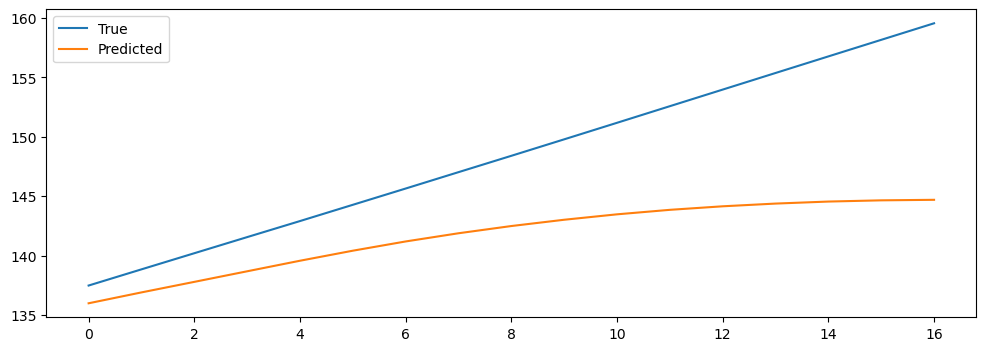

In [14]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 4))
plt.plot(y_test_denorm, label='True')
plt.plot(y_pred_denorm, label='Predicted')
plt.legend()
plt.show()